In [1]:
import numpy as np
from urllib.request import urlopen
import scipy.optimize
import random
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import RidgeClassifier
import pandas as pd

In [2]:
def parseDataFromURL(fname):
  for l in urlopen(fname):
    yield eval(l)

def parseData(fname):
  for l in open(fname):
    yield eval(l)

print("Reading data...")
# Download from http://jmcauley.ucsd.edu/cse255/data/beer/beer_50000.json"
data = list(parseData("data/beer_50000.json"))
print("done")

Reading data...
done


In [3]:
#select data 
categoryCounts = defaultdict(int)
for d in data:
    categoryCounts[d["beer/style"]] += 1

categories = [c for c in categoryCounts if categoryCounts[c] > 1000]
catID = dict(zip(list(categories),range(len(categories))))

In [4]:
catID

{'American Double / Imperial IPA': 0,
 'Rauchbier': 1,
 'American Pale Ale (APA)': 2,
 'American Porter': 3,
 'Russian Imperial Stout': 4,
 'American IPA': 5,
 'Fruit / Vegetable Beer': 6,
 'American Double / Imperial Stout': 7,
 'Rye Beer': 8,
 'Scotch Ale / Wee Heavy': 9,
 'English Pale Ale': 10,
 'Czech Pilsener': 11,
 'Old Ale': 12}

In [5]:
idx = catID.values()
ohe = np.array(np.eye(max(idx) +1).astype(int))


In [6]:
ohe_map = dict(zip(list(categories),ohe))

In [7]:
ohe_map

{'American Double / Imperial IPA': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'Rauchbier': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'American Pale Ale (APA)': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'American Porter': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'Russian Imperial Stout': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'American IPA': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 'Fruit / Vegetable Beer': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 'American Double / Imperial Stout': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Rye Beer': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'Scotch Ale / Wee Heavy': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'English Pale Ale': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 'Czech Pilsener': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 'Old Ale': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])}

In [8]:
for d in data:
    if d['beer/style'] in categories:
        d['beer/style'] = ohe_map[d['beer/style']]
    else:
        d['beer/style'] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
x = np.array([d['beer/style'] for d in data])

In [10]:
ones = np.ones((len(x),1))
ones

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [11]:
X = np.hstack([ones,x])
x_1 = [[d['review/appearance'],d['review/palate'], \
       d['review/taste'],d['review/overall'],d['review/aroma']] for d in data]

x_2 = [len(d['review/text']) for d in data]
x_2 = x_2 / max(np.array(x_2))
x_2 = np.reshape(x_2,(-1,1))

X = np.hstack([X,x_1])
X = np.hstack([X,x_2])
X


array([[1.        , 0.        , 0.        , ..., 1.5       , 2.        ,
        0.05549672],
       [1.        , 0.        , 0.        , ..., 3.        , 2.5       ,
        0.071595  ],
       [1.        , 0.        , 0.        , ..., 3.        , 2.5       ,
        0.08388053],
       ...,
       [1.        , 0.        , 0.        , ..., 3.5       , 3.5       ,
        0.13577632],
       [1.        , 0.        , 0.        , ..., 4.        , 4.        ,
        0.20800678],
       [1.        , 0.        , 0.        , ..., 4.5       , 4.        ,
        0.09510697]])

In [12]:
y = [d['beer/ABV'] > 7.0 for d in data]

In [13]:
#shuffle data
Xy = list(zip(X,y))
random.shuffle(Xy)
X = np.array([d[0] for d in Xy])
y = np.array([d[1] for d in Xy])

In [14]:
Xtrain = X[:len(x)//2]
Xtest = X[len(x)//2:]

ytrain = y[:len(x)//2]
ytest = y[len(x)//2:]

## 1) Train a logistic regressor using this one-hot encoding to predict whether beers have an ABV greater than 7 percent (i.e., d[’beer/ABV’] > 7). Train the classifier on the training set and report its performance in terms of the accuracy and Balanced Error Rate (BER) on the test set, using a regularization constant of C = 10. For all experiments use the class weight=’balanced’ option (2 marks).

In [15]:
logreg = LogisticRegression(C=10, class_weight = 'balanced').fit(Xtrain[:,:14],ytrain)
pred = logreg.predict(Xtest[:,:14])


TP_ = np.logical_and(pred, ytest)
FP_ = np.logical_and(pred, np.logical_not(ytest))
TN_ = np.logical_and(np.logical_not(pred), np.logical_not(ytest))
FN_ = np.logical_and(np.logical_not(pred), ytest)

TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)
FPR = FP/(FP+TN)
FNR = FN/(FN+TP)
print("balanced error rate: ", (1/2)*(FPR+FNR))
print('accuracy: ', accuracy_score(ytest, pred))

balanced error rate:  0.16068652372986186
accuracy:  0.84876


## 2) Extend your model to include two additional features: (1) a vector of five ratings (review/aroma,review/overall, etc.); and (2) the review length (in characters). The length feature should be scaled to be between 0 and 1 by dividing by the maximum length. Using the same value of C from the previous question, report the BER of the new classifier (1 mark).

In [16]:
logreg = LogisticRegression(C=10, class_weight = 'balanced', max_iter = 460).fit(Xtrain,ytrain)
pred = logreg.predict(Xtest)


TP_ = np.logical_and(pred, ytest)
FP_ = np.logical_and(pred, np.logical_not(ytest))
TN_ = np.logical_and(np.logical_not(pred), np.logical_not(ytest))
FN_ = np.logical_and(np.logical_not(pred), ytest)

TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)
FPR = FP/(FP+TN)
FNR = FN/(FN+TP)
print("balanced error rate: ", (1/2)*(FPR+FNR))
print('accuracy: ', accuracy_score(ytest, pred))

balanced error rate:  0.14223937720215946
accuracy:  0.8626


## 3) Implement a complete regularization pipeline with the balanced classifier. Split your test data from above in half so that you have 50%/25%/25% train/validation/test fractions. Consider values of C in the range{10^−6, 10^−5 , 10^−4, 10^−3}. Report (or plot) the train, validation, and test BER for each value of C. Based on these values, which classifier would you select (in terms of generalization performance) and why (1 mark)?

In [17]:
def mse(model, X, y):
    preds = model.predict(X)
    diffs = [(float(a)-float(b))**2 for (a,b) in zip(preds,y)]
    return sum(diffs) / len(diffs)
    

In [18]:
N = len(y)
Ntrain = N//2
Nvalid = N//4
Ntest = N//4

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:Ntrain+Nvalid]
Xtest = X[Ntrain+Nvalid:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:Ntrain+Nvalid]
ytest = y[Ntrain+Nvalid:]

In [19]:
    
C = [10**-6,10**-5,10**-4,10**-3]
bestModel = None
bestMSE = None
for c in C:
    model = LogisticRegression(C = c, class_weight = 'balanced').fit(Xtrain, ytrain)
    preds = [model.predict(Xtrain), model.predict(Xvalid), model.predict(Xtest)]
    ys = [ytrain, yvalid, ytest]
    
    mse_tr = mse(model, Xtrain, ytrain)
    mse_v = mse(model, Xvalid, yvalid)
    print("mse train/validation: " + str(mse_tr),str(mse_v))
    
    print("C value: ", str(c))
    
    titles = ["train BER: ", "valid BER: ", "test BER: "]   
    for m in range(len(preds)):
        TP_ = np.logical_and(preds[m], ys[m])
        FP_ = np.logical_and(preds[m], np.logical_not(ys[m]))
        TN_ = np.logical_and(np.logical_not(preds[m]), np.logical_not(ys[m]))
        FN_ = np.logical_and(np.logical_not(preds[m]), ys[m])

        TP = sum(TP_)
        FP = sum(FP_)
        TN = sum(TN_)
        FN = sum(FN_)
        FPR = FP/(FP+TN)
        FNR = FN/(FN+TP)
        print(titles[m], (1/2)*(FPR+FNR))
    print("\n")

    if not bestModel or mse_v < bestMSE:
        bestModel = model
        bestMSE = (mse_v)
    
    

mse train/validation: 0.3216 0.32384
C value:  1e-06
train BER:  0.3167114713429558
valid BER:  0.3203850384473046
test BER:  0.31577497649604813


mse train/validation: 0.3198 0.32184
C value:  1e-05
train BER:  0.314951238004041
valid BER:  0.31842232410872157
test BER:  0.3145511464911047


mse train/validation: 0.29728 0.30072
C value:  0.0001
train BER:  0.29315496535476443
valid BER:  0.29805167770056334
test BER:  0.2905913557276848


mse train/validation: 0.19412 0.19136
C value:  0.001
train BER:  0.19575385402175077
valid BER:  0.19330076277807476
test BER:  0.18964224229757196




### I would select the classifier with C value of .001, based on the lowest validation MSE and lowest  test BER

In [20]:
bestModel

LogisticRegression(C=0.001, class_weight='balanced')

In [21]:
bestMSE

0.19136

## 4) (CSE158 only) An ablation study measures the marginal benefit of various features by re-training the model with one feature ‘ablated’ (i.e., deleted) at a time. Considering each of the three features in your classifier above (i.e., beer style, ratings, and length), report the BER with only the other two features and the third deleted (1 mark).

In [22]:
C = [10**-6,10**-5,10**-4,10**-3]
Xtrain_ = np.hstack([Xtrain[:,:14],Xtrain[:,-1:]])
Xtest_ = np.hstack([Xtest[:,:14],Xtest[:,-1:]])
Xvalid_ = np.hstack([Xvalid[:,:14],Xvalid[:,-1:]])

toFitX = [Xtrain[:,:-1],
          Xtrain[:,-6:],
          Xtrain_]

toPredTr = [Xtrain[:,:-1],Xtrain[:,-6:],Xtrain_ ]
toPredV = [Xvalid[:,:-1],Xvalid[:,-6:], Xvalid_]
toPredT = [Xtest[:,:-1],Xtest[:,-6:],Xtest_ ]

ablations = ["(ohe styles and ratings)", "(ratings and review length)", "(ohe styles and review length)"]

for c in C:
    print("C value: ", c)
    for i in range(len(toFitX)):
        logreg = LogisticRegression(C=c, class_weight = 'balanced', max_iter = 400).fit(toFitX[i],ytrain)
        trpred = logreg.predict(toPredTr[i])
        vpred = logreg.predict(toPredV[i])
        pred = logreg.predict(toPredT[i])

        
        
        TP_ = np.logical_and(trpred, ytrain)
        FP_ = np.logical_and(trpred, np.logical_not(ytrain))
        TN_ = np.logical_and(np.logical_not(trpred), np.logical_not(ytrain))
        FN_ = np.logical_and(np.logical_not(trpred), ytrain)

        TP = sum(TP_)
        FP = sum(FP_)
        TN = sum(TN_)
        FN = sum(FN_)
        FPR = FP/(FP+TN)
        FNR = FN/(FN+TP)
        print("training balanced error rate: " + ablations[i], (1/2)*(FPR+FNR))
        
        TP_ = np.logical_and(vpred, yvalid)
        FP_ = np.logical_and(vpred, np.logical_not(yvalid))
        TN_ = np.logical_and(np.logical_not(vpred), np.logical_not(yvalid))
        FN_ = np.logical_and(np.logical_not(vpred), yvalid)

        TP = sum(TP_)
        FP = sum(FP_)
        TN = sum(TN_)
        FN = sum(FN_)
        FPR = FP/(FP+TN)
        FNR = FN/(FN+TP)
        print("validation balanced error rate: " + ablations[i], (1/2)*(FPR+FNR))

        TP_ = np.logical_and(pred, ytest)
        FP_ = np.logical_and(pred, np.logical_not(ytest))
        TN_ = np.logical_and(np.logical_not(pred), np.logical_not(ytest))
        FN_ = np.logical_and(np.logical_not(pred), ytest)

        TP = sum(TP_)
        FP = sum(FP_)
        TN = sum(TN_)
        FN = sum(FN_)
        FPR = FP/(FP+TN)
        FNR = FN/(FN+TP)
        print("test balanced error rate: " + ablations[i], (1/2)*(FPR+FNR))
        print("\n")
    print("\n")
        
    

C value:  1e-06
training balanced error rate: (ohe styles and ratings) 0.31654486428633577
validation balanced error rate: (ohe styles and ratings) 0.31945649492166617
test balanced error rate: (ohe styles and ratings) 0.315453673566917


training balanced error rate: (ratings and review length) 0.3402036260149308
validation balanced error rate: (ratings and review length) 0.34117176898721163
test balanced error rate: (ratings and review length) 0.33679075848465934


training balanced error rate: (ohe styles and review length) 0.26728720943897877
validation balanced error rate: (ohe styles and review length) 0.2675420967145031
test balanced error rate: (ohe styles and review length) 0.2668961129439944




C value:  1e-05
training balanced error rate: (ohe styles and ratings) 0.3153848550956065
validation balanced error rate: (ohe styles and ratings) 0.3184022780541963
test balanced error rate: (ohe styles and ratings) 0.3147117979556703


training balanced error rate: (ratings and revi

# Tasks (Community Detection)

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
from urllib.request import urlopen

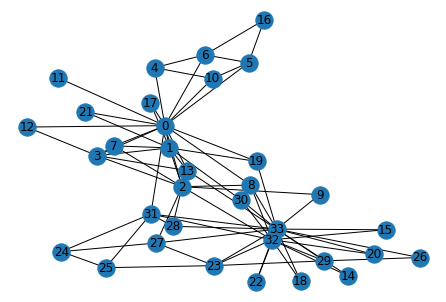

<Figure size 432x288 with 0 Axes>

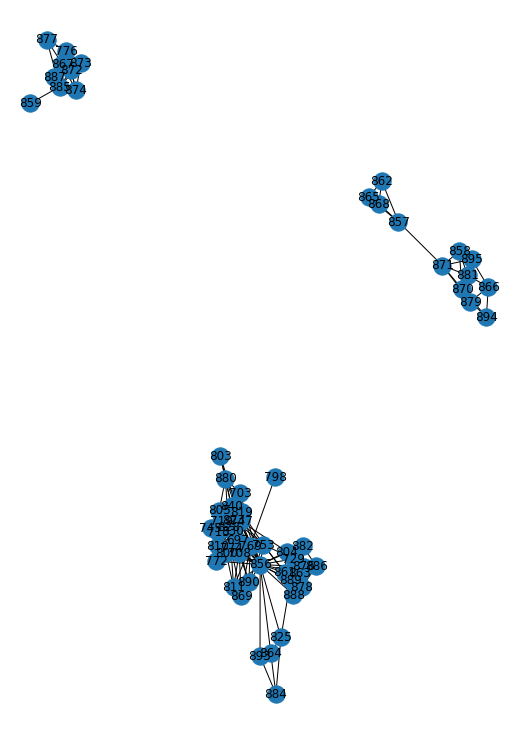

<Figure size 432x288 with 0 Axes>

In [24]:
# Karate club
G = nx.karate_club_graph()
nx.draw(G, with_labels = True)
plt.show()
plt.clf()

edges = set()
nodes = set()
for edge in urlopen("http://cseweb.ucsd.edu/classes/fa19/cse258-a/data/egonet.txt"):
    x,y = edge.split()
    x,y = int(x),int(y)
    edges.add((x,y))
    edges.add((y,x))
    nodes.add(x)
    nodes.add(y)

G = nx.Graph()
plt.figure(figsize=(7,10)) 
for e in edges:
    G.add_edge(e[0],e[1])
nx.draw(G,with_labels = True)
plt.show()
plt.clf()

## 6) How many connected components are in the graph, and how many nodes are in the largest connected component (1 mark)? Next we’ll implement a ‘greedy’ version of normalized cuts, using just the largest connected component found above. First, split it into two equal halves, just by taking the 50% of nodes with the lowest and 50% with the highest IDs.

### There are 3 connected components and 40 nodes in the largest connected component

In [25]:
num_cc = len(list(nx.connected_components(G)))
print(num_cc)
print(len(max(list(nx.connected_components(G)))))

3
40


In [26]:
max_cc = max(list(nx.connected_components(G)))

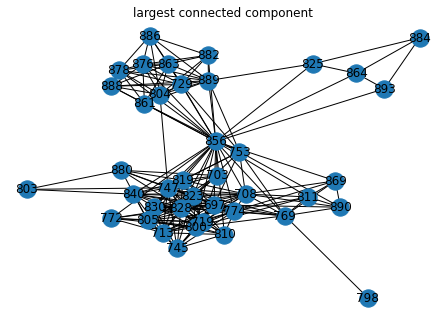

In [27]:
nx.draw(G.subgraph(max_cc), with_labels = True)
plt.title("largest connected component")
plt.show()

In [28]:
nodes_max_cc = max(list(nx.connected_components(G)))
lows, highs = sorted(nodes_max_cc)[:len(nodes_max_cc)//2],sorted(nodes_max_cc)[len(nodes_max_cc)//2:]
lows = set(lows)
highs = set(highs)

## 7) What is the normalized-cut cost of the 50/50 split you found above (1 mark)? Now we’ll implement our greedy algorithm as follows: during each step, we’ll move one node from one cluster to the other, choosing whichever move minimizes the resulting normalized cut cost (in case of a tie, pick the node with the lower ID). Repeat this until the cost can’t be reduced any further.

In [29]:
#number of edges between low cluster and high cluster
def edges_across_cut(graph, set1, set2):
    return len(list(nx.edge_boundary(graph,set1,set2)))

edges_across_cut(G.subgraph(max_cc), lows, highs)

92

In [30]:
G.subgraph(max_cc).degree()

DegreeView({856: 29, 893: 3, 753: 11, 889: 12, 719: 16, 747: 21, 708: 17, 697: 17, 800: 16, 830: 14, 745: 11, 805: 16, 774: 17, 804: 11, 729: 11, 890: 6, 769: 12, 823: 18, 828: 19, 882: 7, 886: 7, 861: 9, 863: 10, 810: 10, 803: 3, 840: 13, 713: 15, 819: 15, 888: 8, 878: 9, 811: 7, 876: 10, 869: 6, 772: 7, 703: 8, 864: 4, 880: 7, 884: 3, 798: 1, 825: 4})

In [31]:
nodes_max_cc = max(list(nx.connected_components(G)))
lows, highs = sorted(nodes_max_cc)[:len(nodes_max_cc)//2],sorted(nodes_max_cc)[len(nodes_max_cc)//2:]
lows = set(lows)
highs = set(highs)

def calc_norm_cut_cost(lows, highs):
    #calcs number of edges across cut
    num_edges = edges_across_cut(G.subgraph(max_cc), lows, highs)
    #calcs sum of degrees in each cluster
    total_low = sum([G.subgraph(max_cc).degree[v] for v in lows])
    total_high = sum([G.subgraph(max_cc).degree[v] for v in highs])
    cost = (1/2)*((num_edges/total_high) + (num_edges/total_low))
    return cost

print("normalized 50/50 split cost: ")
calc_norm_cut_cost(lows, highs)

normalized 50/50 split cost: 


0.42240587695133147

In [32]:
#from piazza:
#Q8 understanding
# So if we have nodes [1,2,3,4,5,6] and after question 7 we have our splits: [1,2,3] and [4,5,6]

# Would the algorithm be finding splits:

# [1,2]/[3,4,5,6],     [1,3]/[2,4,5,6],       [2,3]/[1,4,5,6],     [1,2,3,4]/[5,6],     [1,2,3,5]/[4,6],     [1,2,3,4,6]/[4,5]

# And then finding the minimum normalized cut cost?

# And if [1,2]/[3,4,5,6] was the optimal one, would we proceed like:

# [1],[2,3,4,5,6],    [2]/[1,3,4,5,6],    [1,2,3]/[4,5,6]    [1,2,4]/[3,5,6],     [1,2,5]/[3,4,6],     [1,2,6]/[3,4,5] ?

In [33]:
def greedy(graph, set1, set2):
    min_cost = np.inf
    results1 = {}
#     results2 = {}
    
#     cluster1_2 = set1.copy()
#     cluster2_2 = set2.copy()
    
    for node in set1:
        #Create copies to check for every possible combination
        cluster1 = set1.copy()
        cluster2 = set2.copy()
        #move one node from one to the other
        cluster1.remove(node)
        cluster2.add(node)
        #calc normalized cut cost
        cost = calc_norm_cut_cost(cluster1, cluster2)
        #add node that minimizes cost to outcome dictionary
        if cost < min_cost:
            min_cost = cost
            min_node = node
            results1[min_cost] = min_node
        elif cost == min_cost:
            if node < min_node:
                min_cost = cost
                min_node = node
                results1[min_cost] = min_node
       
    
#     for node in set2:
#         #Create copies
#         cluster1 = set1.copy()
#         cluster2 = set2.copy()
#          #move one node from one to the other
#         cluster2.remove(node)
#         cluster1.add(node)
#         #calc normalized cut cost
#         cost = calc_norm_cut_cost(cluster1, cluster2)
#         if cost < min_cost:
#             min_cost = cost
#             min_node = node
#             results2[min_cost] = min_node
#         elif cost == min_cost:
#             if node < min_node:
#                 min_cost = cost
#                 min_node = node
#                 results2[min_cost] = min_node

    out = {v:k for k, v in sorted(results1.items(), key=lambda item: item[0])}
            
        
                
        
        
    return list(out.items())[0]

In [34]:
greedy(G.subgraph(max_cc),lows,highs)

(729, 0.3873319662793347)

In [35]:
nodes_max_cc = max(list(nx.connected_components(G)))
lows, highs = sorted(nodes_max_cc)[:len(nodes_max_cc)//2],sorted(nodes_max_cc)[len(nodes_max_cc)//2:]
lows = set(lows)
highs = set(highs)


while True:
    prev_cost = calc_norm_cut_cost(lows, highs)
    #move from set1 to set2
    node1, node1_cost = greedy(G.subgraph(max_cc),lows,highs)
    #move from set2 to set1
    node2, node2_cost = greedy(G.subgraph(max_cc),highs,lows)
    #if node cost from cluster 1 to cluster 2 is less than cost from cluster 2 to cluster 1
    #then move node, vice versa
    if node1_cost < node2_cost and node1_cost < prev_cost:
        min_node = node1
        min_cost = node1_cost
        lows.remove(min_node)
        highs.add(min_node)
        print("test1: this is working")
    elif node2_cost < node1_cost and node2_cost < prev_cost:
        min_node = node2
        min_cost = node2_cost
        highs.remove(min_node)
        lows.add(min_node)
        print("test2: this is working")
    #if tie, pick node with lower id
    elif node1_cost == node2_cost:
        if node1 < node2:
            lows.remove(node1)
            highs.add(node1)
            min_cost = node1_cost
            print("test3: this is working")
        else:
            highs.remove(node2)
            lows.add(node2)
            min_cost = node2_cost
            print("test4: this is working")
    else: break
    print("test: reachable statement:")
        
        

print("elements of resulting split: ") 
print("split1: ", lows)
print("split12: ", highs)
print("normalized cut cost: ",  calc_norm_cut_cost(lows, highs))

test1: this is working
test: reachable statement:
test1: this is working
test: reachable statement:
test2: this is working
test: reachable statement:
test2: this is working
test: reachable statement:
test2: this is working
test: reachable statement:
test2: this is working
test: reachable statement:
test2: this is working
test: reachable statement:
test2: this is working
test: reachable statement:
test2: this is working
test: reachable statement:
test2: this is working
test: reachable statement:
elements of resulting split: 
split1:  {769, 772, 774, 798, 800, 803, 805, 810, 811, 819, 823, 697, 828, 830, 703, 708, 840, 713, 719, 856, 869, 745, 747, 880, 753, 890}
split12:  {804, 825, 729, 861, 863, 864, 876, 878, 882, 884, 886, 888, 889, 893}
normalized cut cost:  0.09817045961624274
